<a id="top_page"></a>
# Hubble Space Catalogue Data

This is a notebook that queries Hubble data using the Table Access Protocol using Astronomical Data Query Language(ADQL) and downloads it into specific folders. 

In [1]:
import astropy
from astropy.io import fits
from astropy.table import Table
import astroquery
import time
from astroquery.mast import Catalogs
import pyvo as vo
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
from matplotlib import pyplot as plt
import time
import numpy as np
from scipy.stats import gaussian_kde
import warnings as wr
wr.filterwarnings("ignore")

## Connecting to the STScI Table Access Protocol Endpoint

In [3]:
TAP_URL = "http://vao.stsci.edu/hscv3tap/tapservice.aspx"

In [4]:
TAP_service = vo.dal.TAPService(TAP_URL)
TAP_service.describe()

Capability ivo://ivoa.net/std/TAP

Interface None
    http://vao.stsci.edu/hscv3tap/tapservice.aspx

Language ADQL
Output format application/x-votable+xml
    Also available as votable

Output format text/csv;header=present
    Also available as csv


Capability ivo://ivoa.net/std/DALI#examples-1.0

Interface vr:WebBrowser
    http://vao.stsci.edu/hscv3tap/tapservice.aspx/examples




### List Available Tables and columns 

In [5]:
# List of tables with descriptions
table_list = []
for t in TAP_service.tables: 
    if not "tap_schema" in t.name:        
        table = {'name': t.name, 'description': t.description}
        table_list.append(table)
Table(table_list).show_in_notebook()

idx,name,description
0,dbo.Catalog_ACS_SourceExtractor,"This table contains the Source Extractor information for each single filter, detected, ACS source. Source Extractor is described <a href=""http://adsabs.harvard.edu/abs/1996A%26AS..117..393B""><style=""font-size:medium"">here </a>."
1,dbo.Catalog_Image_MetaData,"This table describes the properties of images and their source lists. The source lists are contained in tables Catalog_WFPC2_SourceExtractor, Catalog_WFC3_SourceExtractor, Catalog_WFPC2_SourceExtractor."
2,dbo.Catalog_WFC3_SourceExtractor,"This table contains the Source Extractor information for each single filter, detected, WFC3 source. Source Extractor is described <a href=""http://adsabs.harvard.edu/abs/1996A%26AS..117..393B""><style=""font-size:medium"">here </a>."
3,dbo.Catalog_WFPC2_SourceExtractor,"This table contains the Source Extractor information for each single filter, detected, WFPC2 source. Source Extractor is described <a href=""http://adsabs.harvard.edu/abs/1996A%26AS..117..393B""><style=""font-size:medium"">here </a>."
4,dbo.CloseMatch,"For each match, this table contains a list of other matches that lie within 1 arcsecond of its position."
5,dbo.ClosestMatch,"This table contains the nearest neighbor for each match in table SumPropMagAper2Cat, provided there is a neighbor that lies with 1 arcsecond of the match. This table is a subset of table CloseMatch."
6,dbo.DetailedCatalog,This table contains the properties of each source in the Hubble Source Catalog.
7,dbo.GroupMembers,This table lists the white light images that make up each group.
8,dbo.Groups,"This table summarizes properties of the image group, a collection of white light images that each intersect with another image in the group."
9,dbo.HLAScience,This table describes the Hubble Legacy Archive images that make up the white light images.


In [6]:
def getTableColumns(tableName):
    col_list = []
    for c in TAP_service.tables[tableName].columns: 
        datum = {'name': c.name, 'description': c.description, 'unit': c.unit}
        col_list.append(datum)
    return(Table(col_list))

In [7]:
columns = getTableColumns("dbo.SumMagAper2CatView")
columns.show_in_notebook()

idx,name,description,unit
0,MatchRA,right ascension coordinate of the match position,degrees
1,MatchDec,declination coordinate of the match position,degrees
2,DSigma,standard deviation of source positions in match,milliarcseconds
3,AbsCorr,indicator of whether the match contains sources that are aligned to a standard catalog,None
4,NumFilters,number of filters in match with sources detected in the aper2 aperture,None
5,NumVisits,number of visits in match with sources detected in the aper2 aperture,None
6,NumImages,"number of Hubble Legacy Archive single filter, visit-combined (level 2) images in match with sources detected in the aper2 aperture",None
7,StartTime,earliest start time of exposures in match with sources detected in the aper2 aperture,time
8,StopTime,latest stop time of exposures in match with sources detected in the aper2 aperture,time
9,StartMJD,modified Julian date (MJD) for earliest start time of exposures in match with sources detected in the aper2 aperture,time


<a id="query"></a>
## ADQL Query

Helpful guides for writing ADQL queries for MAST data: 
* [https://www.ivoa.net/documents/ObsCore/20170509/REC-ObsCore-v1.1-20170509.pdf](https://www.ivoa.net/documents/ObsCore/20170509/REC-ObsCore-v1.1-20170509.pdf)
* [MAST CAOM Tap Example](https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=dc7e419d172c1d1f8c1f4bf56c69b2038510e898&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f4e4153412d4e41564f2f6161735f776f726b73686f705f323031382f646337653431396431373263316431663863316634626635366336396232303338353130653839382f6d6173742f43616f6d5461702e6970796e62&logged_in=false&nwo=NASA-NAVO%2Faas_workshop_2018&path=mast%2FCaomTap.ipynb&platform=android&repository_id=113874284&repository_type=Repository&version=99)

In [8]:
# Little bit of help for coordinates
c = SkyCoord('13h42m11.62s', '+28d22m38.2s', frame='icrs') # RA, DEC, Frame
c

<SkyCoord (ICRS): (ra, dec) in deg
    (205.54841667, 28.37727778)>

In [9]:
query="""
SELECT MatchID, MatchRA, MatchDec, A_F555W, A_F814W
FROM dbo.SumMagAper2CatView
WHERE A_F555W_N > 0 and A_F814W_N > 0
    AND CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',205.5484, 28.3772,0.25))=1
"""

t0 = time.time()
job = TAP_service.run_sync(query)
print(f"Query completed in {time.time()-t0} seconds")
results = job.to_table()
results

Query completed in 33.859848499298096 seconds


MatchID,MatchRA,MatchDec,A_F555W,A_F814W
,degrees,degrees,,
int64,float64,float64,float64,float64
1789259,205.548250612871,28.377113171323,18.7604999542236,18.1267499923706
32109510,205.548182244375,28.3772749072288,18.7957992553711,18.2367000579834
64638437,205.548606246566,28.3771008677909,18.640100479126,18.4071006774902
83166576,205.548151885154,28.3772126462362,19.2285003662109,18.8647994995117
17007988,205.548203159093,28.3770347862635,19.9099998474121,19.7121000289917
98871980,205.548587741204,28.3770071914575,19.5552997589111,18.3059997558594
68490410,205.548628864485,28.3773818906091,20.7789993286133,19.7672996520996
106888226,205.548096194273,28.3773090687891,20.7660999298096,20.318000793457


In [10]:
def getHubbleCMD(catalog, vis, infra, title, save_plot=False, density=False):
    """
    This function uses a catalog from the user as input and returns a 
    colour magnitude diagram for all the stars observed in that catalogue.
    A Look into the photometric System: https://en.wikipedia.org/wiki/Photometric_system
    
        Dependencies: 
            numpy
            matplotlib.pyplot
            scipy.stats.gaussian_kde
            
        Parameters:
            catalog (astropy.table): The catalog to plot a colour magnitude diagram from.
            vis (str): The name of the column with the Visual filter magnitude.
            infra (str): The name of the column with the Infrared filter magnitude.
            title (str): The title of the colour magnitude plot
            save_plot (bool): A flag to save the figure. Defaults to false, to save the figure, change the flag to True
        
        Returns:
            ax(matplotlib.axes._subplots.AxesSubplot): A matplot axes object containing the colour magnitude diagram.
    """
    
    visual = catalog[vis]
    infrared = catalog[infra]
     
    VminusI = visual-infrared
    
    w = np.where((VminusI > -1.5) & (VminusI < 2.5))
    
    # Calculate the point density
    x = np.array(VminusI[w])
    y = np.array(visual[w])
    xy = np.vstack([x,y])
    
    f, ax = plt.subplots(figsize=(7,7))
    ax.set_xlabel(f"{vis}-{infra}", fontsize=12)
    ax.set_ylabel(f"{vis}", fontsize=12)
    ax.invert_yaxis()
    ax.set_title(title)
    plt.text(.12,.95,f'{len(x)} stars', horizontalalignment='center', transform=ax.transAxes, size=13)
    ax.scatter(x, y, s=1, color="red")
    if save_plot:
        f.savefig(title.replace(" ", "_")+".png")
        print(title.replace(" ", "_")+".png"+" saved.")
    return ax

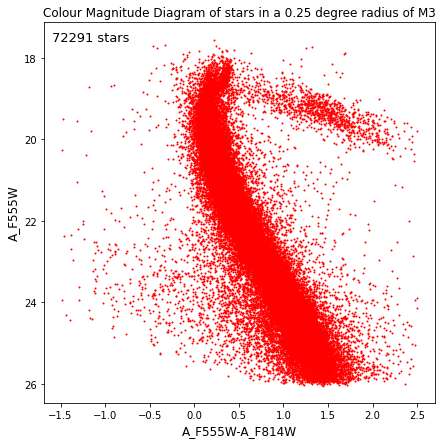

In [11]:
cmd = getHubbleCMD(results, 
             'A_F555W', 
             'A_F814W', 
             f"Colour Magnitude Diagram of stars in a 0.25 degree radius of M3")

## About this Notebook
**Author:** Mikhail Martins<br>
**Last Updated on:** 14th June, 20222

[Top of Page](#top_page)<br>
[ADQL Query](#query)